In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.layers import Input, Conv2D, MaxPooling2D, Flatten, Dense, Activation, BatchNormalization
from keras.models import Model, load_model
from keras.utils import to_categorical
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
import keras.backend as K

%matplotlib inline

K.set_image_data_format('channels_last')

Using TensorFlow backend.


In [2]:
def load_data():
    # Read the MNIST training data
    df = pd.read_csv('data/train.csv')
    X = df.drop(columns=['label'])
    X = X.values.reshape((-1, 28, 28, 1)) / 255.0 
    Y = df['label'].values
    Y = to_categorical(Y, num_classes=10)
    print('X shape:', X.shape)
    print('Y shape:', Y.shape)

    # shuffle training data
    indices = np.arange(len(Y))
    np.random.shuffle(indices)
    X_shuffled = X[indices]
    Y_shuffled = Y[indices]

    # Keep part of data for validation
    index = 40000
    X_train = X_shuffled[:index]
    Y_train = Y_shuffled[:index]
    X_val = X_shuffled[index+1:]
    Y_val = Y_shuffled[index+1:]
    
    return X_train, Y_train, X_val, Y_val

In [3]:
X_train, Y_train, X_val, Y_val = load_data()

X shape: (42000, 28, 28, 1)
Y shape: (42000, 10)


In [ ]:
# view sample data
img_id = 200
plt.imshow(X_train[img_id,:,:,0])  
print(Y_train[img_id])

In [ ]:
def DigitModel():
    # Input placeholder
    X_input = Input((28, 28, 1), name='input')

    # Layer-1 : Conv -> Relu -> Max Pooling
    X = Conv2D(8, (7,7), strides=(1,1), padding='same', name='conv1')(X_input)
    X = Activation('relu', name='a1')(X)
    X = MaxPooling2D((2, 2), strides=(1,1), padding='same', name='max_pool1')(X)
    X = BatchNormalization()(X)
    
    # Layer-2 : conv -> Relu -> Max Pooling
    X = Conv2D(16, (5,5), strides=(1,1), padding='same', name='conv2')(X)
    X = Activation('relu', name='a2')(X)
    X = MaxPooling2D((2, 2), name='max_pool2')(X)
    X = BatchNormalization()(X)
    
    # Layer-3 : conv -> Relu -> Max Pooling
    X = Conv2D(32, (5,5), strides=(1,1), padding='same', name='conv3')(X)
    X = Activation('relu', name='a3')(X)
    #X = MaxPooling2D((2, 2), strides=(1,1), padding='same', name='max_pool3')(X)
    X = MaxPooling2D((2, 2), name='max_pool3')(X)
    X = BatchNormalization()(X)
    
    # Layer-4 : conv -> Relu -> Max Pooling
    X = Conv2D(64, (3,3), strides=(1,1), padding='same', name='conv4')(X)
    X = Activation('relu', name='a4')(X)
    X = MaxPooling2D((2, 2), name='max_pool4')(X)
    X = BatchNormalization()(X)
   
    # Layer-5 : Flatten -> Fully Connected 
    X = Flatten(name='flatten5')(X)
    X = Dense(128, name='dense5')(X)
    X = Activation('relu', name='a5')(X)
    X = BatchNormalization()(X)
    
    # Layer-6 : Softmax
    X = Dense(10, name='dense6')(X)
    Y = Activation('softmax', name='a6')(X)

    # Create keras model
    model = Model(inputs=X_input, outputs=Y, name='DigitModel')
    
    return model

In [ ]:
digit_model = DigitModel()

In [ ]:
digit_model.summary()

In [ ]:
digit_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
# Augment data with more variations
datagen = ImageDataGenerator(
                rotation_range = 10,
                zoom_range = 0.1, 
                width_shift_range = 0.1,  
                height_shift_range = 0.1)  

In [ ]:
# Dynamically reduce the learning rate on plateau
reduce_learning_rate = ReduceLROnPlateau(
                            monitor = 'val_acc', 
                            patience = 3, 
                            verbose = 1, 
                            factor = 0.5, 
                            min_lr = 0.00001)

In [ ]:
num_epochs = 30
digit_model.fit_generator(datagen.flow(X_train, Y_train, batch_size=128), epochs=num_epochs, steps_per_epoch=len(X_train)/128,
                         validation_data=(X_val, Y_val), callbacks=[reduce_learning_rate])

In [ ]:
digit_model.evaluate(X_val, Y_val, batch_size=64)

In [ ]:
digit_model.save('digit_model.h5')

In [ ]:
# Read test data
df = pd.read_csv('data/test.csv')
X_test = df.values.reshape((-1, 28, 28, 1)) / 255.0

In [ ]:
# Predict results for the test data
results = digit_model.predict(X_test)
digits = [np.argmax(r) for r in results]

In [ ]:
# Write the predictions
file = open('data/predictions.csv', 'w')
file.write('ImageId,Label\n')
for i, d in zip(range(len(digits)), digits):
    file.write(str(i+1)+','+str(d)+'\n')
file.close()

In [4]:
# Load model
digit_model = load_model('digit_model.h5')

Label = 0
Prediction = 0


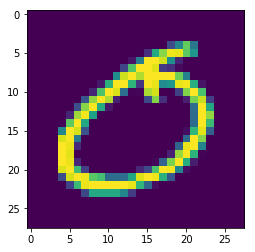

In [5]:
# view sample data and check the prediction
img_id = 450
X = X_val[img_id,:,:,0]
Y = Y_val[img_id]
plt.imshow(X)  
print('Label =', np.argmax(Y))

prediction = digit_model.predict(X.reshape(1,28,28,1))
print('Prediction =', np.argmax(prediction))